In [314]:
import os
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [315]:
data_path = Path(os.getenv('HOME')+'/data')
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


## 데이터 전처리하기
- 같은 UserID를 가진 로그 시간간의 diff가 600초를 넘으면 

In [316]:
# UserId 로 group을 짓고 Time간의 diff를 확인

print(data.groupby('UserId')['Time'].diff())

# UserId의 개수만큼 NaN으로 처리가 되어있음 (다른 UserID까지는 diff 계산 안함)
data.groupby('UserId')['Time'].diff().isna().sum()

31              NaN
22             36.0
27              0.0
37              0.0
24             48.0
             ...   
1000019        31.0
999988         35.0
1000172         0.0
1000167        22.0
1000042    860569.0
Name: Time, Length: 1000209, dtype: float64


6040

In [317]:
time_diff = data.groupby('UserId')['Time'].diff()

SessionId = []
sid = 0

for i in range(len(data)):
    if np.isnan(time_diff.iloc[i]) or time_diff.iloc[i] > 600:
        sid = sid + 1
    SessionId.append(sid)

print(f'len is {len(SessionId)}, max is {max(SessionId)}')

data['SessionId'] = SessionID
data.head()

len is 1000209, max is 28379


,UserId,ItemId,Rating,Time,SessionId
31,1,3186,4,978300019,1
22,1,1270,5,978300055,1
27,1,1721,4,978300055,1
37,1,1022,5,978300055,1
24,1,2340,3,978300103,1


### Session Length

In [318]:
session_length = data.groupby('SessionId').size()
session_length

SessionId
1         12
2         28
3         13
4        129
5         51
        ... 
28375      7
28376     14
28377      1
28378     21
28379      1
Length: 28379, dtype: int64

In [319]:
session_length.median(), session_length.mean()

(6.0, 35.244687973501534)

In [320]:
session_length.min(), session_length.max()

(1, 1193)

In [321]:
long_session = session_length[session_length==1193].index[0]
data[data['SessionId']==long_session]

,UserId,ItemId,Rating,Time,SessionId
637775,3841,1480,3,965995059,18615
637808,3841,969,5,965995059,18615
638269,3841,858,5,965995059,18615
638716,3841,2019,5,965995059,18615
638733,3841,1221,5,965995059,18615
...,...,...,...,...,...
638038,3841,3806,5,966003791,18615
638243,3841,1379,2,966003791,18615
638459,3841,1928,4,966003791,18615
638710,3841,2016,3,966003791,18615


In [322]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

1      0.280101
2      0.383030
3      0.433701
4      0.467775
5      0.498467
         ...   
663    0.998802
670    0.998872
671    0.998908
674    0.998943
680    0.998978
Length: 507, dtype: float64

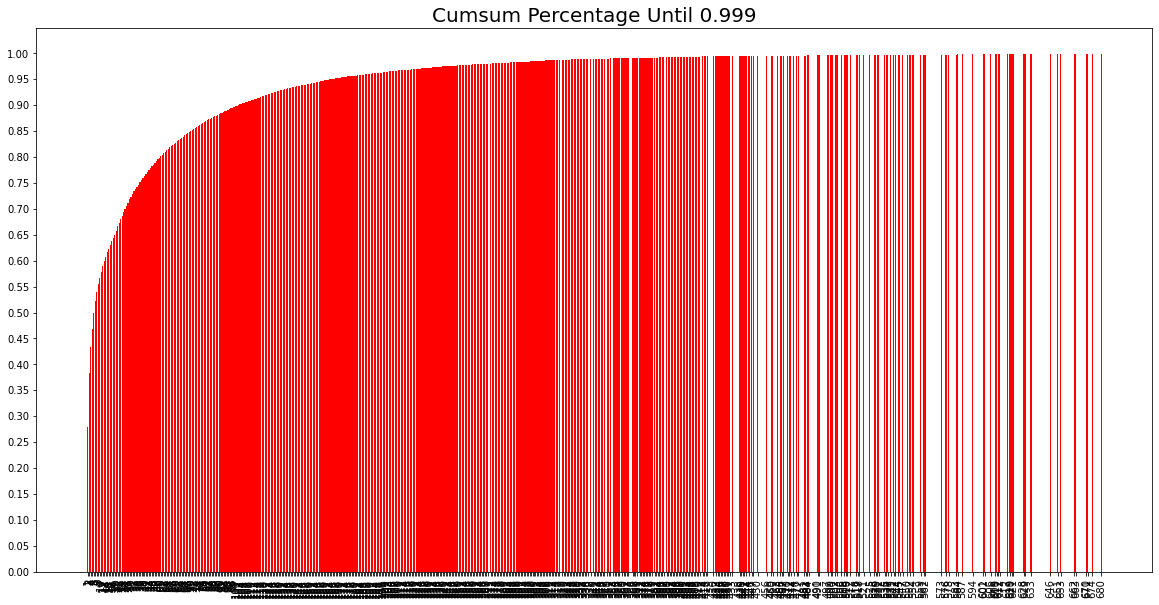

In [323]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index, rotation=90)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

In [324]:
month_ago = 60 * 60 * 24 * 30 * 12 * 2
tmp = data[data['Time'] > data['Time'].max() - month_ago]
tmp

,UserId,ItemId,Rating,Time,SessionId
2327,19,318,4,994556598,48
2492,19,1234,5,994556636,48
2503,20,1694,3,1009669071,50
2512,20,1468,3,1009669071,50
2513,20,3717,2,1009669071,50
...,...,...,...,...,...
1000019,6040,2917,4,997454429,28378
999988,6040,1921,4,997454464,28378
1000172,6040,1784,3,997454464,28378
1000167,6040,161,3,997454486,28378


In [334]:
month_ago = 60 * 60 * 24 * 30 * 12 * 3
tmp = data[data['Time'] > data['Time'].max() - month_ago]
tmp

,UserId,ItemId,Rating,Time,SessionId
31,1,3186,4,978300019,1
22,1,1270,5,978300055,1
27,1,1721,4,978300055,1
37,1,1022,5,978300055,1
24,1,2340,3,978300103,1
...,...,...,...,...,...
999923,6040,232,5,997454398,28378
1000019,6040,2917,4,997454429,28378
999988,6040,1921,4,997454464,28378
1000172,6040,1784,3,997454464,28378


3년전에 값들이 몰려있음. 최근순으로 자르기는 애매할듯

### Data Cleaning

In [326]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [327]:
data = cleanse_recursive(data, shortest=5, least_click=100)
data

,UserId,ItemId,Rating,Time,SessionId
31,1,3186,4,978300019,1
22,1,1270,5,978300055,1
27,1,1721,4,978300055,1
37,1,1022,5,978300055,1
24,1,2340,3,978300103,1
...,...,...,...,...,...
999923,6040,232,5,997454398,28378
1000019,6040,2917,4,997454429,28378
999988,6040,1921,4,997454464,28378
1000172,6040,1784,3,997454464,28378


In [328]:
rate_mean = data.groupby('UserId')['Rating'].mean()
rate_mean

UserId
1       4.192308
2       3.720000
3       3.940000
4       4.190476
5       3.161850
          ...   
6036    3.316261
6037    3.725389
6038    3.866667
6039    3.890756
6040    3.539683
Name: Rating, Length: 6040, dtype: float64

In [329]:
tight_rate = rate_mean.quantile(0.25)
generous_rate = rate_mean.quantile(0.75)
rate_mean = rate_mean[tight_rate < rate_mean]
rate_mean = rate_mean[rate_mean < generous_rate]
rate_mean

UserId
2       3.720000
3       3.940000
6       3.914286
8       3.898438
9       3.750000
          ...   
6033    3.850000
6037    3.725389
6038    3.866667
6039    3.890756
6040    3.539683
Name: Rating, Length: 3020, dtype: float64

In [337]:
data = data[data['UserId'].isin(rate_mean.index)]
data

,UserId,ItemId,Rating,Time,SessionId
130,2,1198,4,978298124,4
64,2,1210,4,978298151,4
71,2,1217,3,978298151,4
134,2,2717,3,978298196,4
88,2,1293,5,978298261,4
...,...,...,...,...,...
999923,6040,232,5,997454398,28378
1000019,6040,2917,4,997454429,28378
999988,6040,1921,4,997454464,28378
1000172,6040,1784,3,997454464,28378


In [383]:
Date = []
for i in range(len(tmp)):
    Date.append(dt.datetime.fromtimestamp(data.iloc[i]['Time']))

len(Date)

445452

In [388]:
data['Date'] = Date
print(data.head())
print(data.tail())

     UserId  ItemId  Rating       Time  SessionId                Date
130       2    1198       4  978298124          4 2000-12-31 21:28:44
64        2    1210       4  978298151          4 2000-12-31 21:29:11
71        2    1217       3  978298151          4 2000-12-31 21:29:11
134       2    2717       3  978298196          4 2000-12-31 21:29:56
88        2    1293       5  978298261          4 2000-12-31 21:31:01
         UserId  ItemId  Rating       Time  SessionId                Date
999923     6040     232       5  997454398      28378 2001-08-10 14:39:58
1000019    6040    2917       4  997454429      28378 2001-08-10 14:40:29
999988     6040    1921       4  997454464      28378 2001-08-10 14:41:04
1000172    6040    1784       3  997454464      28378 2001-08-10 14:41:04
1000167    6040     161       3  997454486      28378 2001-08-10 14:41:26


In [389]:
def split_by_year(data: pd.DataFrame, year: int) -> pd.DataFrame:
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - year].index
    session_in_test = session_last_time[session_last_time >= final_time - year].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [395]:
tr, test = split_by_year(data, year=60*60*24*365)
tr, val = split_by_year(tr, year=60*60*24*365)
len(tr), len(test), len(valid)

(419543, 8132, 17777)

연단위로 데이터셋을 나누어줍니다

In [396]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Date"].min()}\n'
          f'\t Last Time : {data["Date"].max()}\n')

In [397]:
type(tr)

pandas.core.frame.DataFrame

In [398]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 419543
	 Sessions: 6394
	 Items: 1991
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2001-02-25 04:03:55

* valid Set Stats Info
	 Events: 17777
	 Sessions: 688
	 Items: 1952
	 First Time : 2001-02-26 07:52:57
	 Last Time : 2002-02-26 05:01:22

* test Set Stats Info
	 Events: 8132
	 Sessions: 335
	 Items: 1834
	 First Time : 2002-02-27 15:20:04
	 Last Time : 2003-02-26 16:18:03



In [399]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [407]:
save_path = Path(os.getenv('HOME')+'/aiffel/12_data')
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

In [408]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

In [409]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,SessionId,Date,item_idx
130,2,1198,4,978298124,4,2000-12-31 21:28:44,0
64,2,1210,4,978298151,4,2000-12-31 21:29:11,1
71,2,1217,3,978298151,4,2000-12-31 21:29:11,2
134,2,2717,3,978298196,4,2000-12-31 21:29:56,3
88,2,1293,5,978298261,4,2000-12-31 21:31:01,4
170,2,2943,4,978298372,4,2000-12-31 21:32:52,5
106,2,1225,5,978298391,4,2000-12-31 21:33:11,6
120,2,1193,5,978298413,4,2000-12-31 21:33:33,7
172,2,318,5,978298413,4,2000-12-31 21:33:33,8
70,2,3030,4,978298434,4,2000-12-31 21:33:54,9


In [410]:
tr_dataset.click_offsets

array([     0,    125,    175, ..., 419524, 419531, 419543], dtype=int32)

In [411]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 6391, 6392, 6393])

In [412]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [413]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,SessionId,Date,item_idx
130,2,1198,4,978298124,4,2000-12-31 21:28:44,0
64,2,1210,4,978298151,4,2000-12-31 21:29:11,1
71,2,1217,3,978298151,4,2000-12-31 21:29:11,2
134,2,2717,3,978298196,4,2000-12-31 21:29:56,3
88,2,1293,5,978298261,4,2000-12-31 21:31:01,4
170,2,2943,4,978298372,4,2000-12-31 21:32:52,5
106,2,1225,5,978298391,4,2000-12-31 21:33:11,6
120,2,1193,5,978298413,4,2000-12-31 21:33:33,7
172,2,318,5,978298413,4,2000-12-31 21:33:33,8
70,2,3030,4,978298434,4,2000-12-31 21:33:54,9


In [414]:
iter_ex = iter(tr_data_loader)

In [415]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [  0  14 163   1]
Label Item Idx are :       [  1  10  94 220]
Previous Masked Input Idx are []


In [416]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [417]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [418]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [423]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=32, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [424]:
model = create_model(args)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(32, 1, 1991)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 50), (32, 50)]      306450    
_________________________________________________________________
dropout_1 (Dropout)          (32, 50)                  0         
_________________________________________________________________
dense_1 (Dense)              (32, 1991)                101541    
Total params: 407,991
Trainable params: 407,991
Non-trainable params: 0
_________________________________________________________________


In [425]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [426]:
# 학습 시간이 다소 오래 소요됩니다. (예상시간 1시간)
train_model(model, args)

Train:   0%|          | 0/12910 [00:00<?, ?it/s, accuracy=0, train_loss=6.42]     

	 - Recall@20 epoch 1: 0.167819
	 - MRR@20    epoch 1: 0.041866



Train:   0%|          | 0/12910 [00:00<?, ?it/s, accuracy=0, train_loss=5.83]

	 - Recall@20 epoch 2: 0.213091
	 - MRR@20    epoch 2: 0.057304



Evaluation:  93%|█████████▎| 497/534 [01:49<00:08,  4.55it/s]

	 - Recall@20 epoch 3: 0.223969
	 - MRR@20    epoch 3: 0.063322



In [427]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  82%|████████▏ | 200/243 [00:44<00:09,  4.47it/s]

	 - Recall@20: 0.194531
	 - MRR@20: 0.051527



## 회고
### Session 만들기
- UserId를 그룹지은 후 Time의 격차가 6000 이상이면 다른 세션이라고 가정하고 진행하였습니다

### 다른 전처리
- 평점을 매긴 작품의 평균이 중앙인 User들만 모아서 처리하였습니다
- ItemId의 경우 평가받은 항목이 100이상인 것, User의 경우 평가한것이 5이상인 것만 남겨놓았습니다.

### train_loss감소 와 test
- train_loss가 지속적으로 감소하였고, Recall과 MRR지표도 상승하는 모습을 보였습니다.
- test_model도 train의 마지막 epoch과 큰 차이가 없었습니다